In [1]:
from field_free import field_free, field_free_linear
from stark import dipole_me_matrix, field_free_matrix
from thz_field import thz_field
from tdse import propagate
from constants import DEBYE_TIMES_VOLTS_PER_CM_INTO_INVPS, LIGHT_SPEED_CM_PER_PS
import numpy as np
from scipy.interpolate import RegularGridInterpolator
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt

### Molecular data

In [2]:
# rotational constants in 1/cm
rot_b = 0.203

# dipole moment in Debye
dipole_debye = (0, 0, 0.715)

### Field-free rotational energies and wavefunctions

In [3]:
max_j = 3

rot_enr = {}
rot_vec = {}
rot_assignment = {}
rot_func_on_grid = {}

for j in range(max_j + 1):
    rot_enr[j], rot_vec[j], rot_assignment[j], grid, rot_func_on_grid[j] = (
        field_free_linear(j, rot_b)
    )

Print rotational and assignments

In [4]:
print("Rotational energies\n# (J, ka, kc)  E (MHz)")
for j in rot_enr.keys():
    for i, (e, (j, ka, kc)) in enumerate(zip(rot_enr[j], rot_assignment[j])):
        print(i, (j, ka, kc), e)

Rotational energies
# (J, ka, kc)  E (MHz)
0 (0, 0, 0) 0.0
0 (1, 0, 0) 0.406
0 (2, 0, 0) 1.218
0 (3, 0, 0) 2.436


### Rotational matrix elements of dipole moment operator

In [5]:
# dipole matrix elelements
dipole_matrix = dipole_me_matrix(max_j, rot_vec, dipole_debye, linear=True)

# field-free Hamiltonian - diagonal matrix with rotational energies
h0_matrix, assignment = field_free_matrix(max_j, rot_enr, rot_assignment)

Print assignments of rotational states, including the $m$-degeneracy

In [6]:
print("Rotational energies\n# (J, ka, kc, m)  E (MHz)")
for i, (j, ka, kc, m) in enumerate(assignment):
    print(i, (j, ka, kc, m), h0_matrix[i, i])

Rotational energies
# (J, ka, kc, m)  E (MHz)
0 (0, 0, 0, 0) 0.0
1 (1, 0, 0, -1) 0.406
2 (1, 0, 0, 0) 0.406
3 (1, 0, 0, 1) 0.406
4 (2, 0, 0, -2) 1.218
5 (2, 0, 0, -1) 1.218
6 (2, 0, 0, 0) 1.218
7 (2, 0, 0, 1) 1.218
8 (2, 0, 0, 2) 1.218
9 (3, 0, 0, -3) 2.436
10 (3, 0, 0, -2) 2.436
11 (3, 0, 0, -1) 2.436
12 (3, 0, 0, 0) 2.436
13 (3, 0, 0, 1) 2.436
14 (3, 0, 0, 2) 2.436
15 (3, 0, 0, 3) 2.436


### Define THz field

Use the data from `thz_field` module, from https://doi.org/10.1364/OE.24.021059

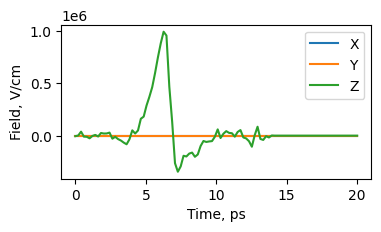

In [7]:
# field, in V/cm, as a function of time, in picoseconds
field = lambda time: np.array([0, 0, thz_field(time, peak_field=100e4)])

time = np.linspace(0, 20, 100)
plt.figure(figsize=(4, 2))
plt.plot(time, np.array([field(t) for t in time]), label=["X", "Y", "Z"])
plt.xlabel("Time, ps")
plt.ylabel("Field, V/cm")
plt.legend()
plt.show()

### Propagate

In [8]:
# convert field-free Hamiltonian from 1/cm to 1/ps
h0_matrix_invps = h0_matrix * LIGHT_SPEED_CM_PER_PS

# convert dipole matrix elelements to units cm/(V*ps)
# ... when we multiply it with field in V/cm, the final units will be 1/ps
dipole_matrix_invps = dipole_matrix * DEBYE_TIMES_VOLTS_PER_CM_INTO_INVPS

# solve TDSE

coefs = np.zeros(len(h0_matrix_invps))
coefs[0] = 1.0

coefs_time = propagate(
    start_time=0.0,
    end_time=500,
    time_step=0.01,
    field=field,
    field_free_matrix=h0_matrix_invps,
    dipole_matrix=dipole_matrix_invps,
    initial_coefs=coefs,
    on_update=lambda i, t, c: (  # print population of state no. 0 at each 100th timestep
        print(
            t.round(2),
            np.abs(c[0]) ** 2,
        )
        if i % 100 == 0
        else None
    ),
)

0.0 0.9999999958069032
1.0 0.9999996105179367
2.0 0.999991390070193
3.0 0.9999549417097147
4.0 0.9974296705227962
5.0 0.9935883069341664
6.0 0.5422104608231908
7.0 0.016562642527637516
8.0 0.13239454426036695
9.0 0.26696124474328603
10.0 0.3086140758542341
11.0 0.2867840953164205
12.0 0.27273350671953833
13.0 0.2910263028043591
14.0 0.30320793042782646
15.0 0.30320793042782646
16.0 0.30320793042782646
17.0 0.30320793042782646
18.0 0.30320793042782646
19.0 0.30320793042782646
20.0 0.30320793042782646
21.0 0.30320793042782646
22.0 0.30320793042782646
23.0 0.30320793042782646
24.0 0.30320793042782646
25.0 0.30320793042782646
26.0 0.30320793042782646
27.0 0.30320793042782646
28.0 0.30320793042782646
29.0 0.30320793042782646
30.0 0.30320793042782646
31.0 0.30320793042782646
32.0 0.30320793042782646
33.0 0.30320793042782646
34.0 0.30320793042782646
35.0 0.30320793042782646
36.0 0.30320793042782646
37.0 0.30320793042782646
38.0 0.30320793042782646
39.0 0.30320793042782646
40.0 0.3032079304278

### Plot populations of states

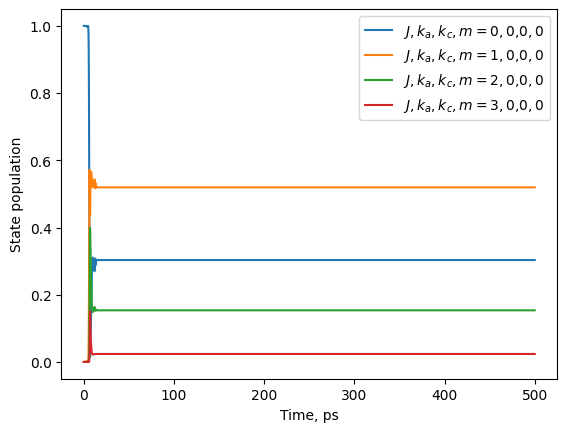

In [9]:
plot_thresh = 1e-1
# extract time grid
time_list = np.array([time for (ind, time, coef) in coefs_time])

populations_time = np.array([np.abs(coef) ** 2 for (ind, time, coef) in coefs_time])

for state_ind, population in enumerate(populations_time.T):
    if np.max(population) > plot_thresh:
        label = "$J,k_a,k_c,m=$"+",".join(f"{elem}$" for elem in assignment[state_ind])
        plt.plot(time_list, population, label=label)
plt.xlabel("Time, ps")
plt.ylabel("State population")
plt.legend()
plt.show()

### Degree of orientation

In [11]:
# recall, in `field_free_linear` we have computed rotational wavefunctions on grid of Euler angles
no_grid_points = len(grid)

# compute field-free rotational wavefunctions on grid, arranged in the same order of functions as used for field-free and dipole matrix elements
func_on_grid = np.concatenate(
    [rot_func_on_grid[j].reshape(-1, no_grid_points) for j in range(max_j + 1)], axis=0
)

# extract wavepacket coefficients
coefs = np.array([coef for (ind, time, coef) in coefs_time])

# compute wavepacket on grid of Euler angles
func_on_grid = np.dot(func_on_grid.T, coefs.T)  # shape = (no_time_steps, no_grid_points)

# compute density on grid of Euler angles multiplied with spherical volume element sin(beta)
dens_on_grid = np.abs(func_on_grid) * np.abs(func_on_grid)# * np.sin(grid[:, 1])[:, None]
print(dens_on_grid.shape)

1
1
1
1
(27000, 50000)


### Monte-Carlo evaluation of the degree of orientation

In [ ]:
npoints = 30
alpha = np.linspace(0, 2 * np.pi, npoints)
beta = np.linspace(0, np.pi, npoints)
gamma = np.linspace(0, 2 * np.pi, npoints)
fdens = RegularGridInterpolator(
    (alpha, beta, gamma), dens_on_grid.reshape(npoints, npoints, npoints, -1)
)
max_dens = np.max(dens_on_grid, axis=0)

npoints = 1000
points = np.random.uniform(
    low=[0, 0, 0], high=[2 * np.pi, np.pi, 2 * np.pi], size=(npoints, 3)
)
dens = fdens(points) / max_dens
eta = np.random.uniform(0.0, 1.0, size=len(dens))
points = [points[np.where(d > eta)] for d in dens.T]

# from Euler angles -> rotation matrix
rotmat = [Rotation.from_euler("zyz", pts).as_matrix() for pts in points]
print(rotmat[0].shape)

z_axis = [0, 0, -1]
Z_axis = [np.dot(rot, z_axis) for rot in rotmat]
cos_theta = np.array([np.mean(v[:, -1]) for v in Z_axis])

plt.plot(time_list, cos_theta)
# pts = np.random.uniform(low=[0,0,0], high=[2*np.pi,np.pi,2*np.pi], size=(npoints,3))
# w = fdens(pts) / max_dens
# eta = np.random.uniform(0.0, 1.0, size=len(w))
# points = [pts[np.where(ww > eta)] for ww in w.T]

# # rotation matrix for Euler angle samples
# rotmat = [R.from_euler('zyz', pts).as_matrix() for pts in points]